In [2]:
import os
import json
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from datetime import datetime, timedelta
from prometheus_api_client.utils import parse_datetime
from prometheus_api_client import PrometheusConnect

In [3]:
path = "../../Result_json/"
file_list = os.listdir(path)
airflow_files = [file for file in file_list if file.startswith("airflow")]
airbyte_files = [file for file in file_list if file.startswith("normalized_airbyte")]

# Sort list
airflow_files = sorted(airflow_files)
airbyte_files = sorted(airbyte_files)

print(airflow_files, airbyte_files, sep='\n')

['airflow_populate_source.txt', 'airflow_populate_target.txt', 'airflow_status.txt']
['normalized_airbyte_populate_source.txt', 'normalized_airbyte_populate_target.txt', 'normalized_airbyte_status.txt']


In [4]:
source, target, status = [], [], []
for file, lst in zip(airflow_files, [source, target, status]):
    with open(path + file) as f:
        for line in f:
            temp_json = json.loads(line)
            temp_json['framework'] = "Airflow + Spark"
            lst.append(temp_json)
            
for file, lst in zip(airbyte_files, [source, target]):
    with open(path + file) as f:
        for line in f:
            temp_json = json.loads(line)
            temp_json['framework'] = "Airbyte"
            lst.append(temp_json)        
            
            
status_airbyte = []
with open(path + airbyte_files[-1]) as f:
    for line in f:
        temp_json = json.loads(line)
        temp_json['framework'] = "Airbyte"
        status_airbyte.append(temp_json)                     

In [5]:
source = pd.DataFrame.from_dict(source, orient='columns').explode(["tables_names", "rows_count", "total_size_bytes"]).reset_index(drop=True)
target = pd.DataFrame.from_dict(target, orient='columns').explode(["tables_names", "rows_count", "total_size_bytes"]).reset_index(drop=True)
status = pd.DataFrame.from_dict(status, orient='columns')
status_airbyte = pd.DataFrame.from_dict(status_airbyte, orient='columns')

display(source.head(3))
display(target.head(3))
display(status.head(3))
display(status_airbyte.head(3))

,benchmark_id,operation,start_time,end_time,sf,tables_names,rows_count,total_size_bytes,framework
0,MjAyMzExMDgxMjM3NDQ=,populate_db,1.699447e+09,1.699447e+09,3,cashtransaction,361856,41091072,Airflow + Spark
1,MjAyMzExMDgxMjM3NDQ=,populate_db,1.699447e+09,1.699447e+09,3,dailymarket,1282768,98697216,Airflow + Spark
2,MjAyMzExMDgxMjM3NDQ=,populate_db,1.699447e+09,1.699447e+09,3,date,25933,7340032,Airflow + Spark


,benchmark_id,sf,tables_names,rows_count,total_size_bytes,framework
0,MjAyMzExMDgxMjM3NDQ=,3,cashtransaction,361856,40615936,Airflow + Spark
1,MjAyMzExMDgxMjM3NDQ=,3,dailymarket,1282768,98213888,Airflow + Spark
2,MjAyMzExMDgxMjM3NDQ=,3,date,25933,6856704,Airflow + Spark


,benchmark_id,startTime,endTime,TimeDelta,operation,framework
0,MjAyMzExMDgxMjM3NDQ=,2023-11-08T12:38:07.590649+00:00,2023-11-08T12:39:14.198780+00:00,66.61,sync_airflow,Airflow + Spark
1,MjAyMzExMDgxMjM5MTU=,2023-11-08T12:39:41.551226+00:00,2023-11-08T12:41:04.374189+00:00,82.82,sync_airflow,Airflow + Spark
2,MjAyMzExMDgxMjQxMDk=,2023-11-08T12:41:40.638150+00:00,2023-11-08T12:43:19.428467+00:00,98.79,sync_airflow,Airflow + Spark


,jobId,jobType,startTime,bytesSynced,rowsSynced,TimeDelta,Throughput,operation,benchmark_id,framework
0,123,sync,2023-11-07 13:58:54,6.107011e+08,4525390.0,192,23569.74,sync_airbyte,MjAyMzExMDcxMzU4MjA=,Airbyte
1,125,sync,2023-11-07 14:02:49,8.317040e+08,6160471.0,252,24446.31,sync_airbyte,MjAyMzExMDcxNDAyMDk=,Airbyte
2,127,sync,2023-11-07 14:07:47,1.043358e+09,7779939.0,327,23791.86,sync_airbyte,MjAyMzExMDcxNDA3MDU=,Airbyte


In [6]:
# Source Fix types
source.rows_count = source.rows_count.astype(int)
source.total_size_bytes = source.total_size_bytes.astype(np.int64)
source.start_time = pd.to_datetime(source.start_time, unit='s')
source.end_time = pd.to_datetime(source.end_time, unit='s')
# Target Fix types
target.rows_count = target.rows_count.astype(int)
target.total_size_bytes = target.total_size_bytes.astype(np.int64)
# Source fix types
status.startTime = pd.to_datetime(status.startTime.str.replace("+00:00", ""), format="%Y-%m-%dT%H:%M:%S.%f")
status.endTime = pd.to_datetime(status.endTime.str.replace("+00:00", ""), format="%Y-%m-%dT%H:%M:%S.%f")
# status_airbyte fix types
status_airbyte.startTime = pd.to_datetime(status_airbyte.startTime, format="%Y-%m-%d %H:%M:%S")

# Source create time_delta
source["time_delta"] = (source.end_time - source.start_time).dt.total_seconds()


In [7]:
source_grouped = source.groupby(["framework", "benchmark_id", "sf"]).agg({"rows_count": "sum", "total_size_bytes": "sum", "time_delta": "max"}).reset_index()
target_grouped = target.groupby(["framework", "benchmark_id", "sf"]).agg({"rows_count": "sum", "total_size_bytes": "sum"}).reset_index()

# join source and status
target_status = target[["framework", "benchmark_id", "sf"]].merge(status, left_on=["framework", "benchmark_id"], right_on=["framework", "benchmark_id"], how="inner")
target_status = target_status.groupby(["framework", "benchmark_id", "sf"]).TimeDelta.max().reset_index()
# join source and status aibyte
target_status_airbyte = target[["framework", "benchmark_id", "sf"]].merge(status_airbyte, left_on=["framework", "benchmark_id"], right_on=["framework", "benchmark_id"], how="inner")
target_status_airbyte = target_status_airbyte.groupby(["framework", "benchmark_id", "sf"]).TimeDelta.max().reset_index()

source_status_combined = pd.concat([target_status, target_status_airbyte])

# Calculate Aiflow + Spark Throughput
temp_join = target_status.merge(target_grouped, left_on=["framework", "benchmark_id", "sf"], right_on=["framework", "benchmark_id", "sf"], how="inner")
temp_join["Throughput"] = temp_join.rows_count / temp_join.TimeDelta
temp_join = temp_join[['framework', 'benchmark_id' , "sf", 'TimeDelta', 'Throughput']]

# target_grouped
df_throughput = status_airbyte[['benchmark_id', 'TimeDelta', 'framework']].merge(target_grouped, left_on=["framework", "benchmark_id"], right_on=["framework", "benchmark_id"], how="inner")
df_throughput['Throughput'] = df_throughput.rows_count / df_throughput.TimeDelta
df_throughput = pd.concat([temp_join, df_throughput])

display(source_grouped.head(3))
display(target_status.head(3))

,framework,benchmark_id,sf,rows_count,total_size_bytes,time_delta
0,Airbyte,MjAyMzExMDcxMzU4MjA=,3,4525390,413368320,17.896000
1,Airbyte,MjAyMzExMDcxNDA3MDU=,5,7779939,704872448,25.865250
2,Airbyte,MjAyMzExMDcxNDAyMDk=,4,6160471,562806784,23.860181


,framework,benchmark_id,sf,TimeDelta
0,Airflow + Spark,MjAyMzExMDgxMjM3NDQ=,3,66.61
1,Airflow + Spark,MjAyMzExMDgxMjM5MTU=,4,82.82
2,Airflow + Spark,MjAyMzExMDgxMjQ1NTk=,7,130.50


In [8]:
mask = source_grouped.framework == "Airflow + Spark"
# Transform in dictionary, sf as key, total_size_bytes as value
temp = source_grouped.loc[mask, ["sf", "total_size_bytes"]]
temp.total_size_bytes = temp.total_size_bytes.astype(float)
temp.sf = temp.sf.astype(int)
temp.total_size_bytes = temp.total_size_bytes.apply(lambda x: round(x/ 1024 / 1024 /1024, 1))
temp.sort_values(by="sf", inplace=True)
print([ str(x)+"GB" for x in temp.total_size_bytes.to_list()])

['0.4GB', '0.5GB', '0.7GB', '0.8GB', '0.9GB', '1.1GB', '1.3GB', '1.6GB', '1.9GB', '2.3GB', '2.7GB', '3.2GB', '3.9GB', '4.7GB', '5.6GB', '6.7GB', '8.1GB', '9.7GB', '11.5GB']


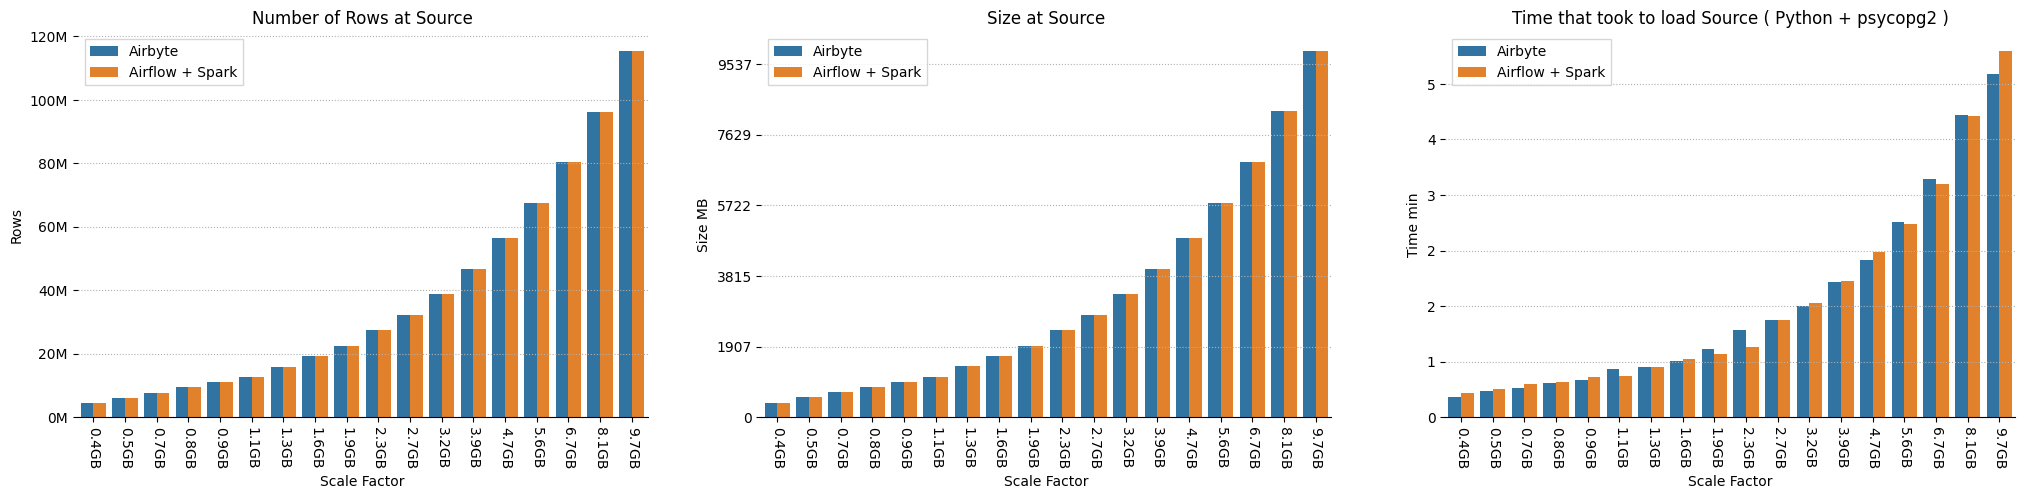

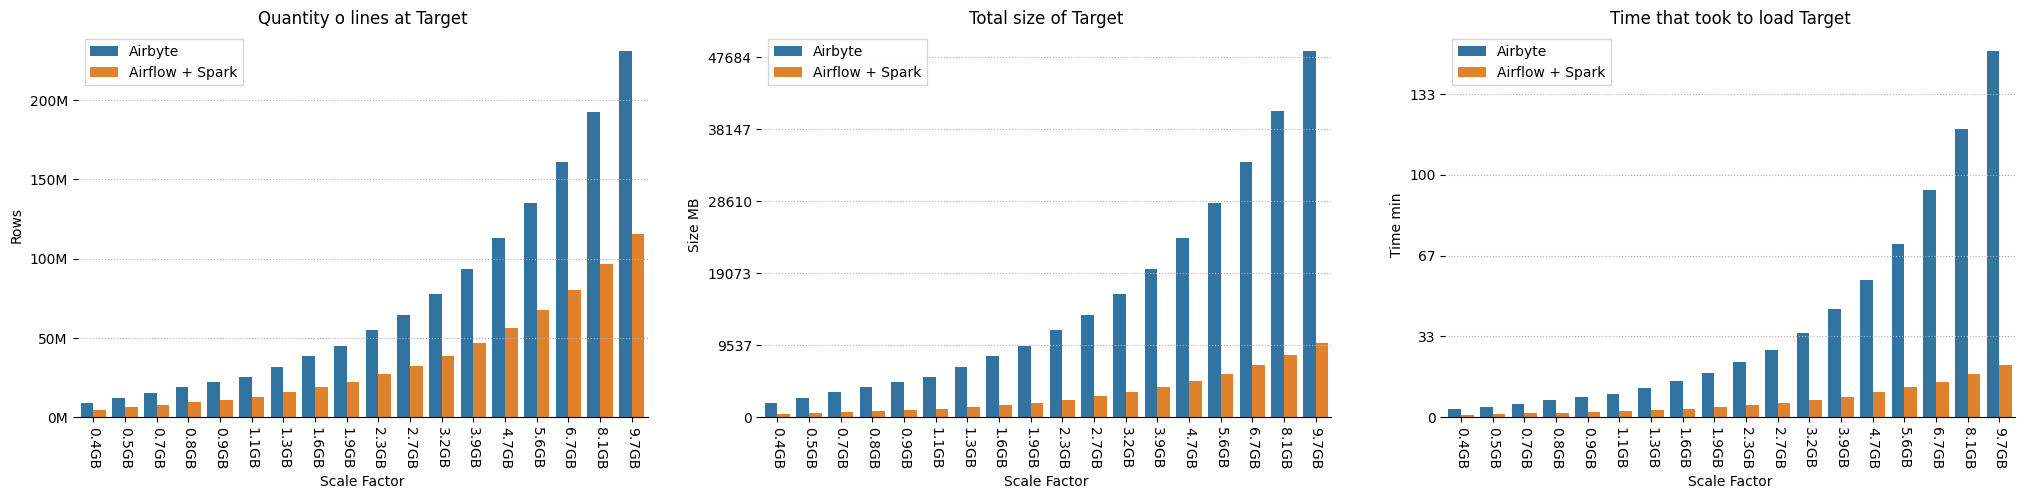

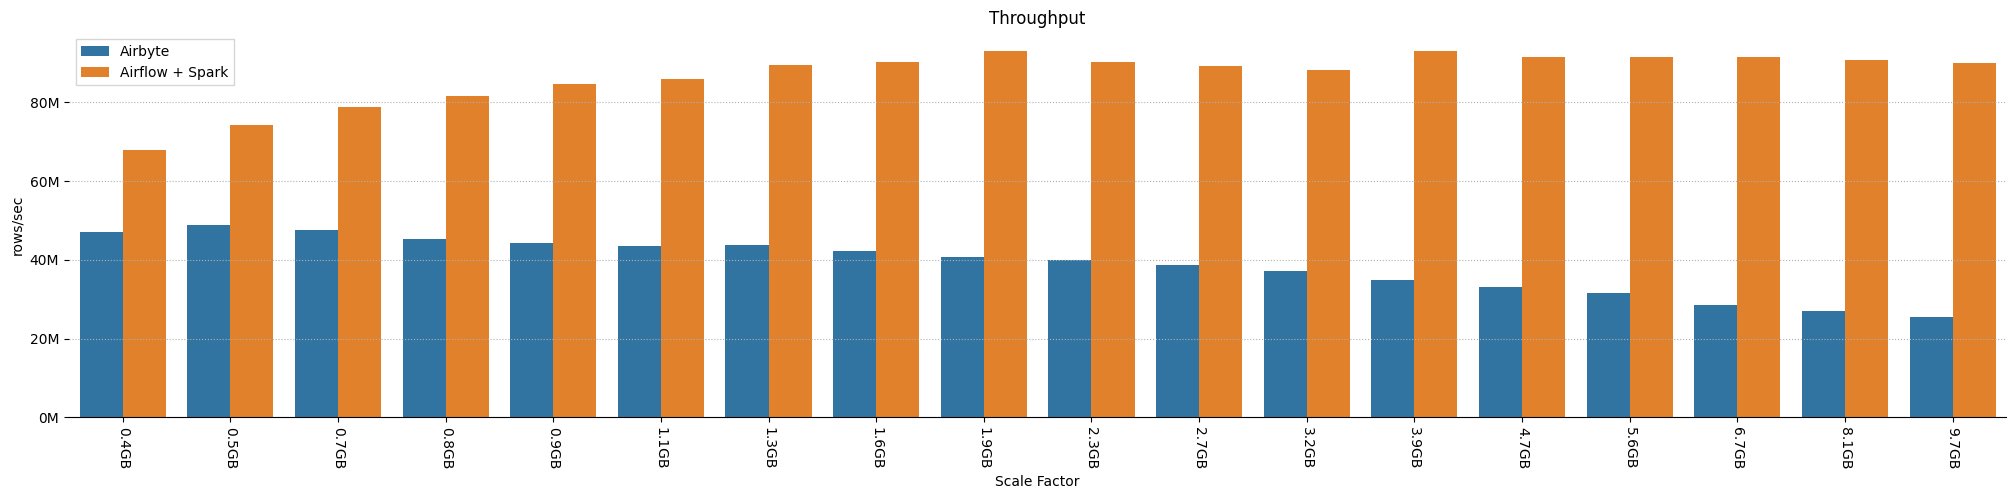

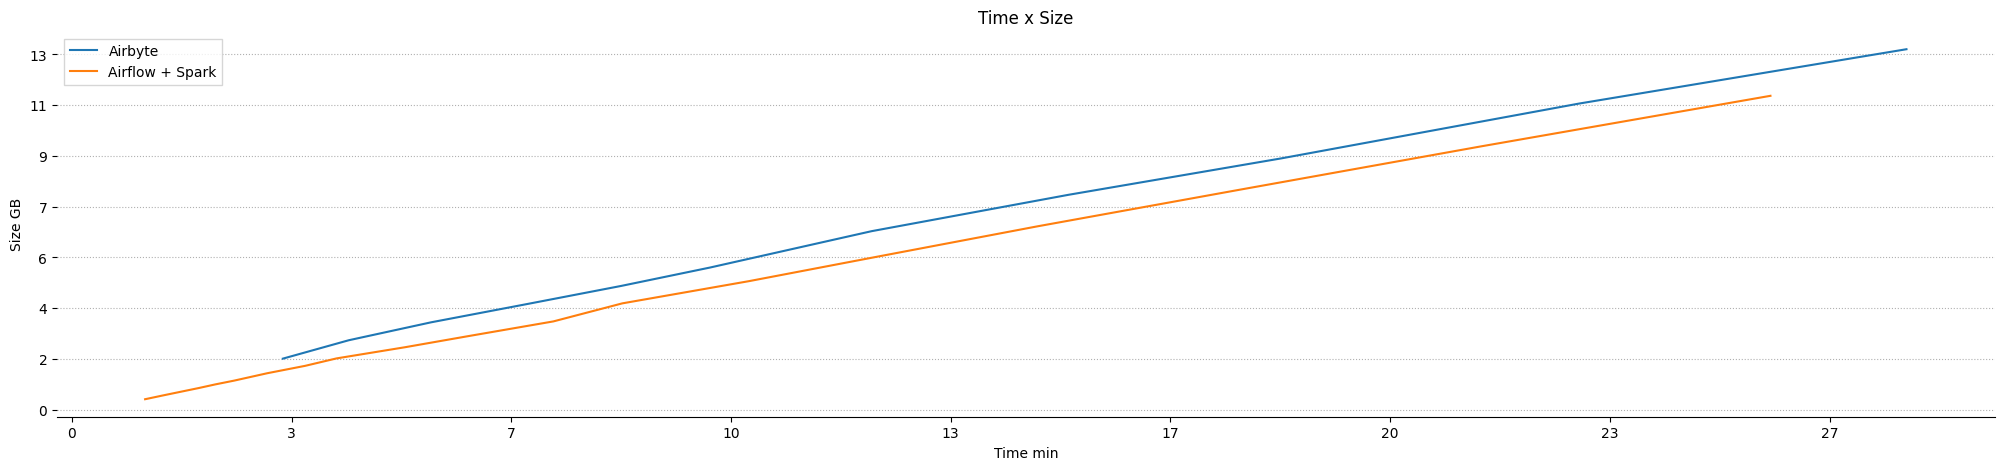

In [14]:
x_tick_labels = ['0.4GB', '0.5GB', '0.7GB', '0.8GB', '0.9GB', '1.1GB', '1.3GB', '1.6GB', '1.9GB', '2.3GB', '2.7GB', '3.2GB', '3.9GB', '4.7GB', '5.6GB', '6.7GB', '8.1GB', '9.7GB']#, '11.5GB']
fig, ax = plt.subplots(1, 3, figsize=(25, 5))
# sns.barplot(x="sf", y="time_delta", color="green", data=python_df, ax=ax[2])
mask = source_grouped.sf < 86
for idx, col in enumerate(["rows_count", "total_size_bytes", "time_delta"]):
    g = sns.barplot(x="sf", y=col, hue="framework", data=source_grouped[mask], ax=ax[idx])
    if idx == 0:
        # Set y-axis scale to millions with separators
        ax[idx].yaxis.set_major_formatter(lambda x, pos: '{:.0f}'.format(x/1000000) + 'M')
        ax[idx].set(ylabel="Rows", xlabel="Scale Factor", title="Number of Rows at Source")
    elif idx == 1:
        # Set y-axis frequency to rise by 2000 until 14000
        # ax[idx].yaxis.set_major_locator(range(0, 14000, 2000))
        ax[idx].yaxis.set_major_formatter(lambda x, pos: '{:.0f}'.format(x/1024/1024))
        ax[idx].set(ylabel="Size MB", xlabel="Scale Factor", title='Size at Source')
    else:
        ax[idx].yaxis.set_major_formatter(lambda x, pos: '{:.0f}'.format(x/60))
        ax[idx].set(ylabel="Time min", xlabel="Scale Factor", title="Time that took to load Source ( Python + psycopg2 )")
    ax[idx].set_xticks(range(len(x_tick_labels)))
    ax[idx].set_xticklabels(x_tick_labels)
    # rotate x_tick_labels 90º
    for item in g.get_xticklabels():
        item.set_rotation(270)
    ax[idx].grid(axis='y', linestyle=':')
    ax[idx].legend(fancybox=False)
sns.despine(left=True)
plt.show()

fig, ax = plt.subplots(1, 3, figsize=(25, 5))
mask = target_grouped.sf < 86
for idx, col in enumerate(["rows_count", "total_size_bytes"]):
    g = sns.barplot(x="sf", y=col, hue="framework", data=target_grouped[mask], ax=ax[idx])
    if idx == 0:
        # Set y-axis scale to millions with separators
        ax[idx].yaxis.set_major_formatter(lambda x, pos: '{:.0f}'.format(x/1000000) + 'M')
        ax[idx].set(ylabel="Rows", xlabel="Scale Factor", title="Quantity o lines at Target")
    else:
        # Divide by 1024 to get MB
        ax[idx].yaxis.set_major_formatter(lambda x, pos: '{:.0f}'.format(x/1024/1024))
        ax[idx].set(ylabel="Size MB", xlabel="Scale Factor", title="Total size of Target")
        
    ax[idx].set_xticks(range(len(x_tick_labels)))
    ax[idx].set_xticklabels(x_tick_labels)
    # rotate x_tick_labels 90º
    for item in g.get_xticklabels():
        item.set_rotation(270)
    ax[idx].grid(axis='y', linestyle=':')
    ax[idx].legend(fancybox=False)
# sns.despine(left=True)
# plt.show()

source_status_combined = source_status_combined.sort_values(by=["framework", "sf"]).reset_index(drop=True)
mask = source_status_combined.sf < 86
g = sns.barplot(x="sf", y="TimeDelta", hue="framework", data=source_status_combined[mask], ax=ax[2])
# Set y-axis scale to millions with separators
ax[2].yaxis.set_major_formatter(lambda x, pos: '{:.0f}'.format(x/60))
ax[2].set_xticks(range(len(x_tick_labels)))
ax[2].set_xticklabels(x_tick_labels)
# rotate x_tick_labels 90º
for item in g.get_xticklabels():
    item.set_rotation(270)
ax[2].set(ylabel="Time min", xlabel="Scale Factor", title="Time that took to load Target")
ax[2].grid(axis='y', linestyle=':')
ax[2].legend(fancybox=False)
sns.despine(left=True)
plt.show()

df_throughput = df_throughput.sort_values(by=["framework", "sf"]).reset_index(drop=True)
mask = df_throughput.sf < 86
fig, ax = plt.subplots(figsize=(25, 5))
g = sns.barplot(x="sf", y="Throughput", hue="framework", data=df_throughput[mask], ax=ax)
# Set y-axis scale to millions with separators
ax.set_xticks(range(len(x_tick_labels)))
ax.set_xticklabels(x_tick_labels)
# rotate x_tick_labels 90º
for item in g.get_xticklabels():
    item.set_rotation(270)
ax.yaxis.set_major_formatter(lambda x, pos: '{:,.0f}'.format(x/1000) + 'M')
ax.set(ylabel="rows/sec", xlabel="Scale Factor", title="Throughput")
ax.grid(axis='y', linestyle=':')
ax.legend(fancybox=False)
sns.despine(left=True)
plt.show()

temp_df = target_grouped.merge(source_status_combined, left_on=["framework", "benchmark_id", "sf"], right_on=["framework", "benchmark_id", "sf"], how="inner")

fig, ax = plt.subplots(figsize=(25, 5))
mask = temp_df.TimeDelta < 33*60
sns.lineplot(x="TimeDelta", y="total_size_bytes", hue="framework", data=temp_df[mask], ax=ax)
# Set y-axis scale to millions with separators
ax.yaxis.set_major_formatter(lambda x, pos: '{:.0f}'.format(x/1024/1024/1024))
ax.xaxis.set_major_formatter(lambda x, pos: '{:.0f}'.format(x/60))
ax.set(ylabel="Size GB", xlabel="Time min", title="Time x Size")
ax.grid(axis='y', linestyle=':')
ax.legend(fancybox=False)
sns.despine(left=True)
plt.show()

# Post Analisys

In [15]:
url = 'http://192.168.1.126:9090'
# Connect
prom = PrometheusConnect(url=url, disable_ssl=True)

my_metrics = [
    "node_cpu_seconds_total", # Seconds the CPUs spent in each mode
    "node_filesystem_avail_bytes", # Filesystem space available to non-root users in bytes.
    "node_filesystem_size_bytes", # Filesystem size in bytes.
    "node_memory_Buffers_bytes", # Memory information field Buffers_bytes.
    "node_memory_Cached_bytes", # Memory information field Cached_bytes.
    'node_memory_SReclaimable_bytes',
    'node_memory_MemFree_bytes',
    'node_memory_MemTotal_bytes',
    "pg_stat_database_tup_deleted",
    "pg_stat_database_tup_fetched",
    "pg_stat_database_tup_inserted",
    "pg_stat_database_tup_returned",
    "pg_stat_database_tup_updated",
    "pg_database_size_bytes"
]

In [16]:
status_fixed_time = status.copy()
status_fixed_time = status_fixed_time.merge(target_grouped, left_on=["framework", "benchmark_id"],
                                            right_on=["framework", "benchmark_id"], how="inner")

cols = ['benchmark_id', 'startTime', 'TimeDelta', "operation", "framework", "sf", "rows_count", "total_size_bytes"]
status_fixed_time = pd.concat([status_fixed_time, status_airbyte.merge(target_grouped, left_on=["framework", "benchmark_id"], right_on=["framework", "benchmark_id"], how="inner")[cols]])

mask = status_fixed_time.endTime.isnull()
status_fixed_time.loc[mask, "endTime"] = status_fixed_time.loc[mask, "startTime"] + status_fixed_time.loc[mask, "TimeDelta"].apply(lambda x: timedelta(seconds=x))
status_fixed_time.reset_index(drop=True, inplace=True)
status_fixed_time.startTime = status_fixed_time.startTime
status_fixed_time.endTime = status_fixed_time.endTime

status_fixed_time.tail(3)

,benchmark_id,startTime,endTime,TimeDelta,operation,framework,sf,rows_count,total_size_bytes
34,MjAyMzExMDcyMDEwNTY=,2023-11-07 20:15:14,2023-11-07 21:48:53,5619.0,sync_airbyte,Airbyte,50,160908902,35449126912
35,MjAyMzExMDcyMTUwMDg=,2023-11-07 21:55:49,2023-11-07 23:54:50,7141.0,sync_airbyte,Airbyte,60,192679040,42459979776
36,MjAyMzExMDcyMzU2MTc=,2023-11-08 00:02:28,2023-11-08 02:33:41,9073.0,sync_airbyte,Airbyte,72,231094320,50900983808


In [17]:
def return_metrics(query, start_time, end_time):
    metric = prom.custom_query_range(
                query=query,  # this is the metric name and label config
                start_time=start_time,
                end_time=end_time,
                step="1m"
                )
    
    return metric
    
df_metrics = pd.DataFrame(columns=["benchmark_id", "framework", "sf", "instance", "cpu_usage", "memory_usage", 'memory_buffer', 'filesystem_size']) 
instances_list = ["Airflow + Spark", "Airbyte"]
for ins in instances_list:
    fin_ins = "|" + ins.upper() if ins == "Airbyte" else "|Airflow".upper()
    
    query_cpu = f'sum by(instance)(irate(node_cpu_seconds_total{{mode=~"user|system", instance=~"SOURCE|TARGET{fin_ins}"}}[1m])) / on(instance) group_left sum by(instance)(irate(node_cpu_seconds_total{{instance=~"SOURCE|TARGET{fin_ins}"}}[1m]))'
    query_memory = f'node_memory_MemTotal_bytes{{instance=~"SOURCE|TARGET{fin_ins}"}} - node_memory_MemFree_bytes{{instance=~"SOURCE|TARGET{fin_ins}"}} - (node_memory_Cached_bytes{{instance=~"SOURCE|TARGET{fin_ins}"}} + node_memory_Buffers_bytes{{instance=~"SOURCE|TARGET{fin_ins}"}} + node_memory_SReclaimable_bytes{{instance=~"SOURCE|TARGET{fin_ins}"}})' 
    query_buffer = f'node_memory_Cached_bytes{{instance=~"SOURCE|TARGET{fin_ins}"}} + node_memory_Buffers_bytes{{instance=~"SOURCE|TARGET{fin_ins}"}} + node_memory_SReclaimable_bytes{{instance=~"SOURCE|TARGET{fin_ins}"}}'
    query_fs_size = f'node_filesystem_size_bytes{{instance=~"SOURCE|TARGET{fin_ins}", mountpoint="/"}} - node_filesystem_avail_bytes{{instance=~"SOURCE|TARGET{fin_ins}", mountpoint="/"}}'
    
    mask = status_fixed_time.framework == ins
    print(status_fixed_time[mask].framework.unique())
    for row in status_fixed_time[mask].itertuples():
        
        test_id = row.benchmark_id
        test_sf = row.sf
        framework = row.framework
        # CPU Consume

        # t_delta = timedelta(hours=3)
        start_time = row.startTime
        end_time = row.endTime
        # print(start_time, end_time, sep=" - ")
        #start_time = datetime.strptime('2023-11-08 10:20:00.652962', '%Y-%m-%d %H:%M:%S.%f')#temp_row.startTime
        #end_time = datetime.strptime('2023-11-08 11:00:00.652962', '%Y-%m-%d %H:%M:%S.%f')#temp_row.endTime
        
        cpu_metric = return_metrics(query=query_cpu, start_time=start_time, end_time=end_time)
        ram_used_metric = return_metrics(query=query_memory, start_time=start_time, end_time=end_time)
        ram_buffer_metric = return_metrics(query=query_buffer, start_time=start_time, end_time=end_time)
        fs_size = return_metrics(query=query_fs_size, start_time=start_time, end_time=end_time)
        
        for cpu_item, memory_used_item, memory_buffer_item, fs_item in zip(cpu_metric, ram_used_metric, ram_buffer_metric, fs_size):
            cpu_instance = cpu_item['metric']['instance']
            cpu_usage = np.array(cpu_item['values'])[:,1]
            memory_used_usage = np.array(memory_used_item['values'])[:,1]
            memory_buffer_usage = np.array(memory_buffer_item['values'])[:,1]
            fs_usage = np.array(fs_item['values'])[:,1]
            
            aux_metrics = pd.Series([framework, test_id, test_sf, cpu_instance, cpu_usage, memory_used_usage, memory_buffer_usage, fs_usage],
                                    index=['framework', "benchmark_id", "sf", "instance", "cpu_usage", "memory_usage", 'memory_buffer', 'filesystem_size'], name=0).to_frame().T    
            df_metrics = pd.concat([df_metrics, aux_metrics], ignore_index=True)

['Airflow + Spark']
['Airbyte']


In [18]:
df_cpu = df_metrics[['benchmark_id', 'framework', 'sf', 'instance', 'cpu_usage']].explode("cpu_usage").reset_index(drop=True)
df_memory = df_metrics[['benchmark_id', 'framework', 'sf', 'instance', 'memory_usage']].explode("memory_usage").reset_index(drop=True)
df_buffer = df_metrics[['benchmark_id', 'framework', 'sf', 'instance', 'memory_buffer']].explode("memory_buffer").reset_index(drop=True)
df_fs = df_metrics[['benchmark_id', 'framework', 'sf', 'instance', 'filesystem_size']].explode("filesystem_size").reset_index(drop=True)

In [19]:
for idx, ii in enumerate([df_cpu, df_memory, df_buffer, df_fs]):
    cols = ii.columns
    ii.sf = ii.sf.astype(int)
    ii[cols[-1]] = ii[cols[-1]].astype(float)
    if idx == 0:
        ii[cols[-1]] = ii[cols[-1]] * 100
    elif idx == 3:
        ii[cols[-1]] = ii[cols[-1]] / 1000 / 1000 / 1000
    else:
        ii[cols[-1]] = ii[cols[-1]] / 1024 / 1024 / 1024
    
    temp = ii.melt(id_vars=["benchmark_id", "framework", "sf", 'instance'])
    temp = temp[['framework', 'sf', 'instance', 'value']]

In [16]:
# df_cpu.to_csv("../../Result_json/cpu_usage.csv", index=False)
# df_memory.to_csv("../../Result_json/memory_usage.csv", index=False)
# df_buffer.to_csv("../../Result_json/memory_buffer.csv", index=False)
# df_fs.to_csv("../../Result_json/filesystem_size.csv", index=False)

# df_cpu = pd.read_csv("../../Result_json/cpu_usage.csv")
# df_memory = pd.read_csv("../../Result_json/memory_usage.csv")
# df_buffer = pd.read_csv("../../Result_json/memory_buffer.csv")
# df_fs = pd.read_csv("../../Result_json/filesystem_size.csv")

In [40]:
def accum_stats(df, mask, df_result, uni_list, col, res, momme):
    mask_frame = df.framework == "Airbyte"
    for idx, ii in zip(x_tick_labels, uni_list):
        mask_sf = df.sf == ii
        print(ii)
        v1 = df.loc[mask & mask_frame & mask_sf, col].to_list()
        v2 = df.loc[mask & ~mask_frame & mask_sf, col].to_list()
        
        stat, p_value = stats.mannwhitneyu(v1, v2)
        mask = (df_result.Resource == momme) & (df_result.Size == idx) & (df_result.Sf == ii)
        print(df_result[mask].index)
        # df_result.loc[[momme, res, idx, ii, p_value]
    # return df_result

In [41]:
uni_list = [ 3,  4,  5,  6,  7,  8, 10, 12, 14, 17, 20, 24, 29, 35, 42, 50, 60, 72]
resources = ["SOURCE"] * len(uni_list) + ["ETL"] * len(uni_list) + ["TARGET"] * len(uni_list)
df_result = pd.DataFrame(columns=["Resource",  "Size", "Sf", "CPU", "RAM", "BUFFER", "FS"])
df_result.Size = x_tick_labels * 3
df_result.Sf = uni_list * 3
df_result.Resource = resources
display(df_result.head(3))

mask = (df_cpu.instance == "AIRFLOW") | (df_cpu.instance == "AIRBYTE")
accum_stats(df_cpu, mask, df_result, uni_list, "cpu_usage", "CPU", "ETL")

,Resource,Size,Sf,CPU,RAM,BUFFER,FS
0,SOURCE,0.4GB,3,NaN,NaN,NaN,NaN
1,SOURCE,0.5GB,4,NaN,NaN,NaN,NaN
2,SOURCE,0.7GB,5,NaN,NaN,NaN,NaN


3
Index([18], dtype='int64')
4


ValueError: `x` and `y` must be of nonzero size.

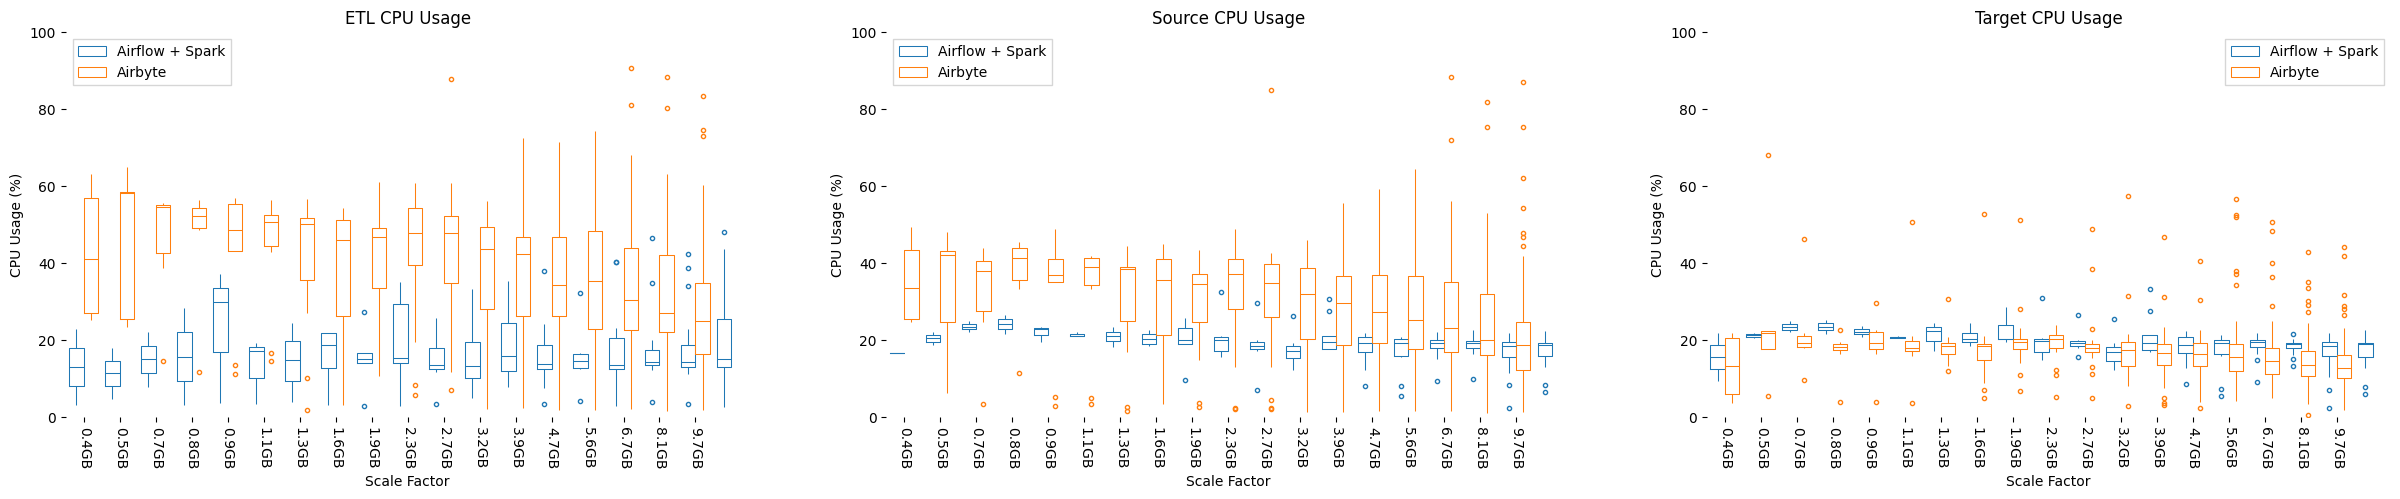

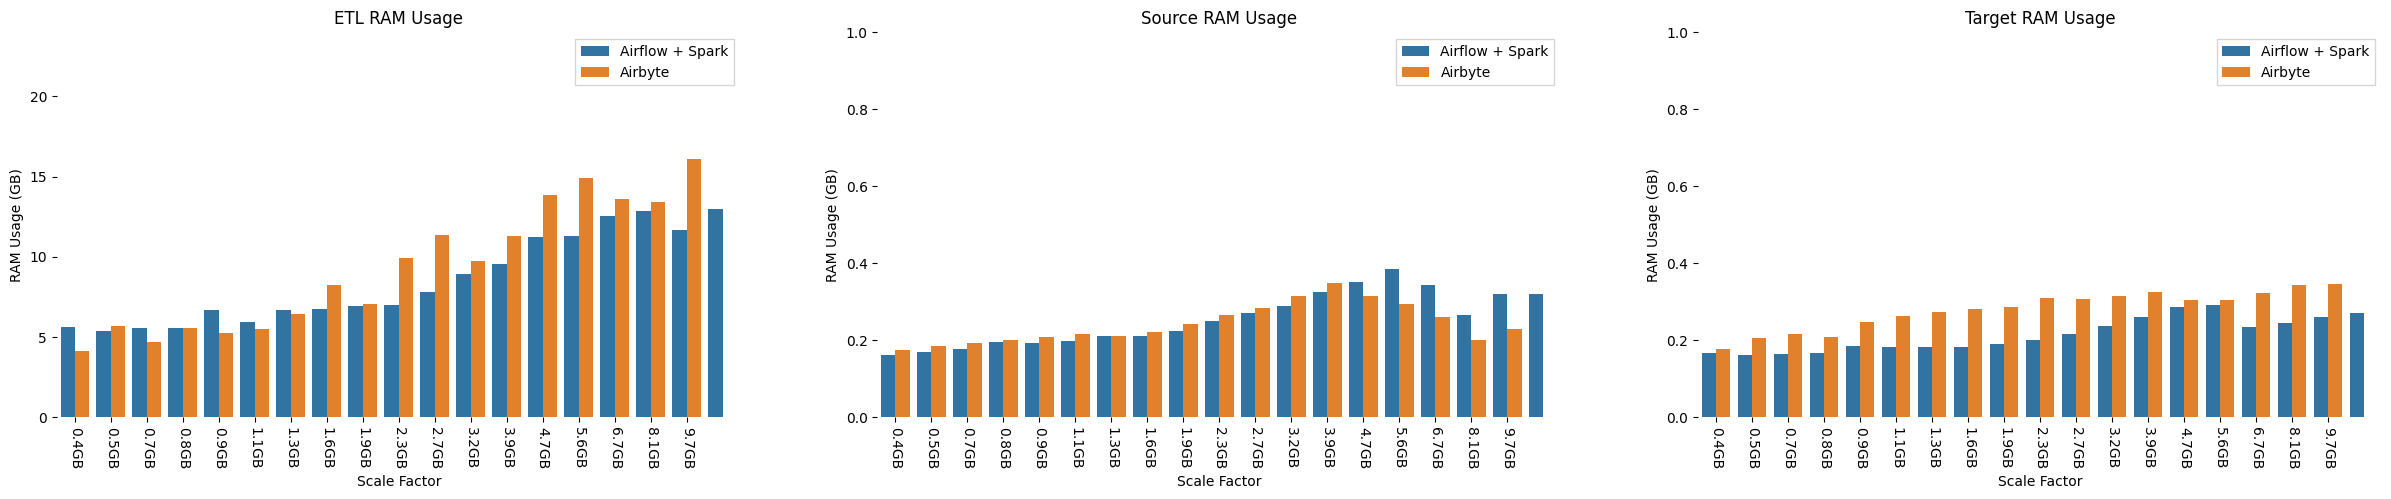

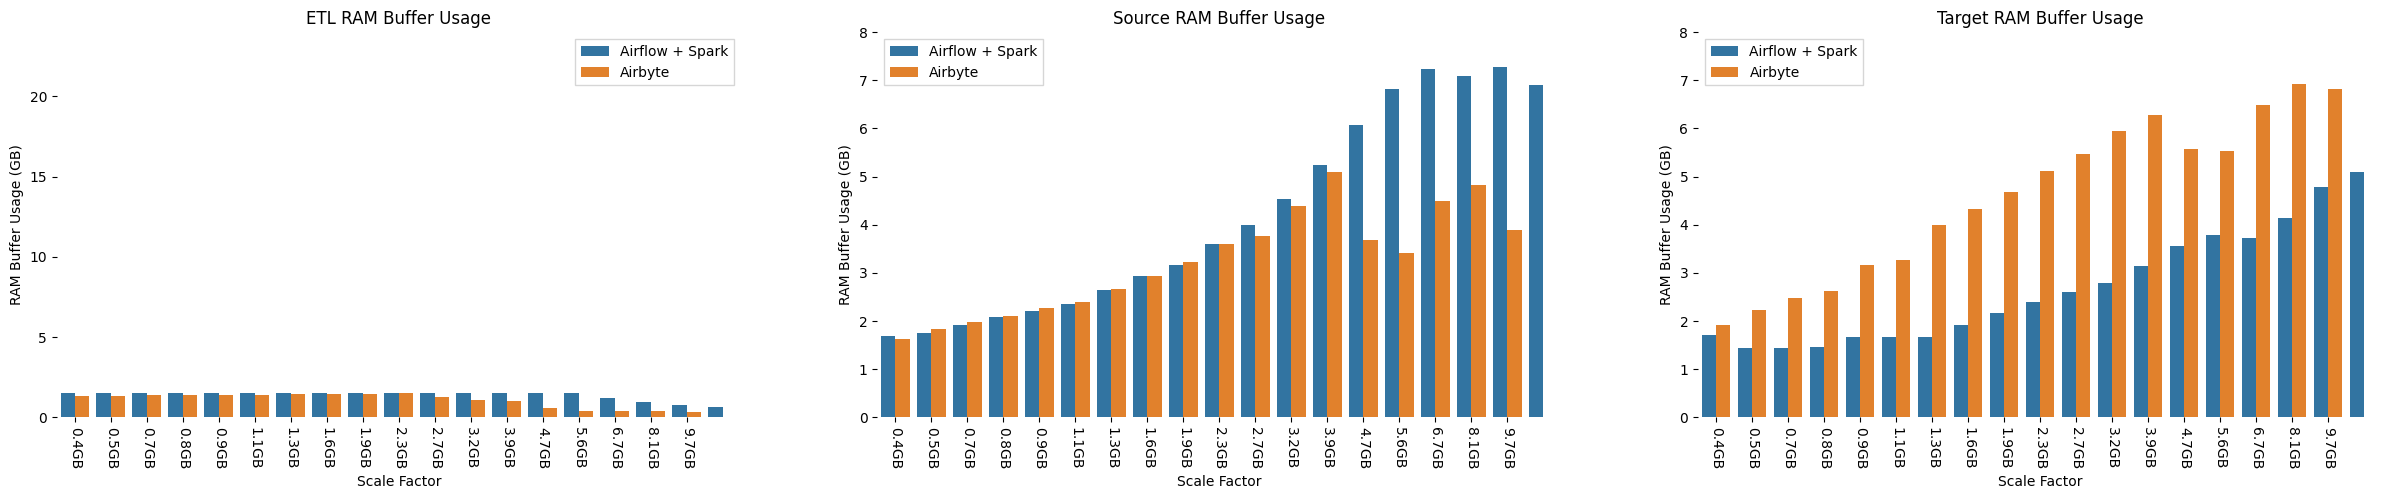

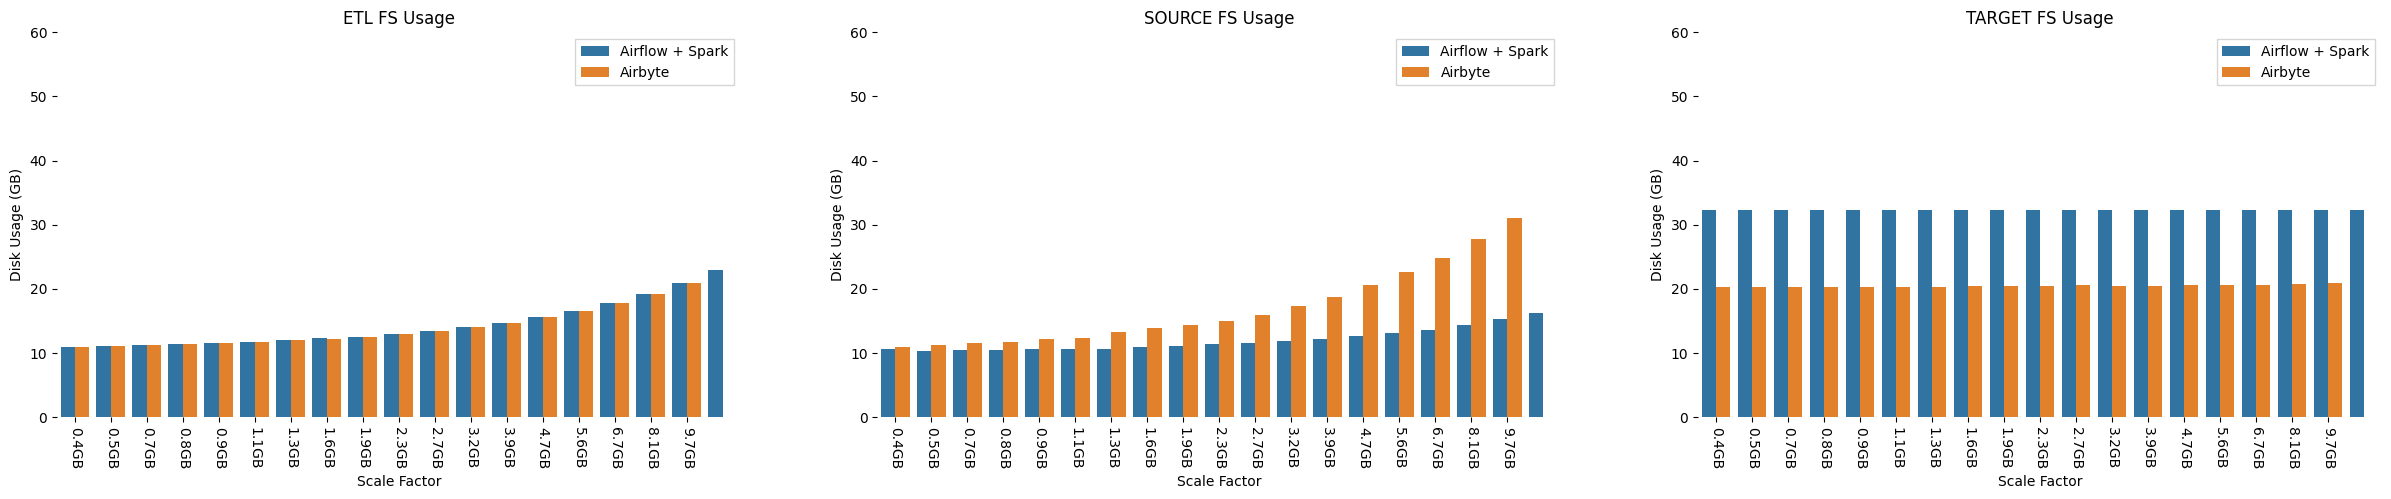

In [21]:
uni_list = [ 3,  4,  5,  6,  7,  8, 10, 12, 14, 17, 20, 24, 29, 35, 42, 50, 60, 72]
resources = ["SOURCE"] * len(uni_list) + ["ETL"] * len(uni_list) + ["TARGET"] * len(uni_list)
df_result = pd.DataFrame(columns=["Resource",  "Size", "Sf", "CPU", "RAM", "BUFFER", "FS"])
df_result.Size = x_tick_labels * 3
df_result.Sf = uni_list * 3
df_result.Resource = resources

# CPU
fig, ax = plt.subplots(1, 3, figsize=(30, 5))
mask = (df_cpu.instance == "AIRFLOW") | (df_cpu.instance == "AIRBYTE")

df_result = accum_stats(df_cpu, mask, df_result, uni_list, "cpu_usage", "CPU", "ETL")

g = sns.boxplot(df_cpu[mask], x='sf', y='cpu_usage', hue='framework', ax=ax[0],
            fill=False, linewidth=.75, flierprops={"marker": "."}, showcaps=False
            ).set(ylim=(0, 100), title="ETL CPU Usage", xlabel="Scale Factor",
             ylabel="CPU Usage (%)", xticks=range(len(x_tick_labels)), xticklabels=x_tick_labels)
ax[0].set_xticklabels(ax[0].get_xticklabels(),rotation=270)
ax[0].legend(fancybox=False)

mask = df_cpu.instance == "SOURCE"
df_result= accum_stats(df_cpu, mask, df_result, "cpu_usage", "CPU", "SOURCE")    
sns.boxplot(df_cpu[mask], x='sf', y='cpu_usage', hue='framework', ax=ax[1],
            fill=False, linewidth=.75, flierprops={"marker": "."}, showcaps=False
            ).set(ylim=(0, 100), title="Source CPU Usage", xlabel="Scale Factor",
             ylabel="CPU Usage (%)", xticks=range(len(x_tick_labels)), xticklabels=x_tick_labels)
ax[1].set_xticklabels(ax[0].get_xticklabels(),rotation=270)
ax[1].legend(fancybox=False)

mask = df_cpu.instance == "TARGET"
df_result= accum_stats(df_cpu, mask, df_result, "cpu_usage", "CPU", "TARGET")
sns.boxplot(df_cpu[mask], x='sf', y='cpu_usage', hue='framework', ax=ax[2],
            fill=False, linewidth=.75, flierprops={"marker": "."}, showcaps=False
            ).set(ylim=(0, 100), title="Target CPU Usage", xlabel="Scale Factor",
             ylabel="CPU Usage (%)", xticks=range(len(x_tick_labels)), xticklabels=x_tick_labels)
ax[2].set_xticklabels(ax[0].get_xticklabels(),rotation=270)
ax[2].legend(fancybox=False)
sns.despine(left=True, bottom=True)
plt.show()

# RAM
fig, ax = plt.subplots(1, 3, figsize=(30, 5))
mask = (df_memory.instance == "AIRFLOW") | (df_memory.instance == "AIRBYTE")
df_result= accum_stats(df_memory, mask, df_result, "memory_usage", "RAM", "ETL")    
sns.barplot(df_memory[mask], x='sf', y='memory_usage', hue='framework', ax=ax[0], errorbar=None).set(ylim=(0,24),
        title="ETL RAM Usage", xlabel="Scale Factor", ylabel="RAM Usage (GB)", xticks=range(len(x_tick_labels)), xticklabels=x_tick_labels)
ax[0].set_xticklabels(ax[0].get_xticklabels(),rotation=270)
ax[0].legend(fancybox=False)

mask = df_memory.instance == "SOURCE"
df_result= accum_stats(df_memory, mask, df_result, "memory_usage", "RAM", "SOURCE")    
sns.barplot(df_memory[mask], x='sf', y='memory_usage', hue='framework', ax=ax[1], errorbar=None).set(ylim=(0,1),
        title="Source RAM Usage", xlabel="Scale Factor", ylabel="RAM Usage (GB)", xticks=range(len(x_tick_labels)), xticklabels=x_tick_labels)
ax[1].set_xticklabels(ax[0].get_xticklabels(),rotation=270)
ax[1].legend(fancybox=False)
mask = df_memory.instance == "TARGET"
df_result= accum_stats(df_memory, mask, df_result, "memory_usage", "RAM", "TARGET")    
sns.barplot(df_memory[mask], x='sf', y='memory_usage', hue='framework', ax=ax[2], errorbar=None).set(ylim=(0,1),
        title="Target RAM Usage", xlabel="Scale Factor", ylabel="RAM Usage (GB)", xticks=range(len(x_tick_labels)), xticklabels=x_tick_labels)
ax[2].set_xticklabels(ax[0].get_xticklabels(),rotation=270)
ax[2].legend(fancybox=False)
sns.despine(left=True, bottom=True)
plt.show()

# RAM Buffer
fig, ax = plt.subplots(1, 3, figsize=(30, 5))
mask = (df_buffer.instance == "AIRFLOW") | (df_buffer.instance == "AIRBYTE")
df_result= accum_stats(df_buffer, mask, df_result, "memory_buffer", "BUFFER", "ETL")
sns.barplot(df_buffer[mask], x='sf', y='memory_buffer', hue='framework', ax=ax[0], errorbar=None).set(ylim=(0,24),
        title="ETL RAM Buffer Usage", xlabel="Scale Factor", ylabel="RAM Buffer Usage (GB)", xticks=range(len(x_tick_labels)), xticklabels=x_tick_labels)
ax[0].set_xticklabels(ax[0].get_xticklabels(),rotation=270)
ax[0].legend(fancybox=False)
mask = df_buffer.instance == "SOURCE"
df_result= accum_stats(df_buffer, mask, df_result, "memory_buffer", "BUFFER", "SOURCE")
sns.barplot(df_buffer[mask], x='sf', y='memory_buffer', hue='framework', ax=ax[1], errorbar=None).set(ylim=(0,8),
        title="Source RAM Buffer Usage", xlabel="Scale Factor", ylabel="RAM Buffer Usage (GB)", xticks=range(len(x_tick_labels)), xticklabels=x_tick_labels)
ax[1].set_xticklabels(ax[0].get_xticklabels(),rotation=270)
ax[1].legend(fancybox=False)
mask = df_buffer.instance == "TARGET"
df_result= accum_stats(df_buffer, mask, df_result, "memory_buffer", "BUFFER", "TARGET")
sns.barplot(df_buffer[mask], x='sf', y='memory_buffer', hue='framework', ax=ax[2], errorbar=None).set(ylim=(0,8),
        title="Target RAM Buffer Usage", xlabel="Scale Factor", ylabel="RAM Buffer Usage (GB)", xticks=range(len(x_tick_labels)), xticklabels=x_tick_labels)
ax[2].set_xticklabels(ax[0].get_xticklabels(),rotation=270)
ax[2].legend(fancybox=False)
sns.despine(left=True, bottom=True)
plt.show()

# Filesystem
fig, ax = plt.subplots(1, 3, figsize=(30, 5))
mask = (df_fs.instance == "AIRFLOW") | (df_fs.instance == "AIRBYTE")
df_result= accum_stats(df_fs, mask, df_result, "filesystem_size", "FS", "ETL")
sns.barplot(df_fs[mask], x='sf', y='filesystem_size', hue='framework', ax=ax[0], errorbar=None).set(ylim=(0,60),
        title="ETL FS Usage", xlabel="Scale Factor", ylabel="Disk Usage (GB)", xticks=range(len(x_tick_labels)), xticklabels=x_tick_labels)
ax[0].set_xticklabels(ax[0].get_xticklabels(),rotation=270)
ax[0].legend(fancybox=False)
mask = df_fs.instance == "SOURCE"
df_result= accum_stats(df_fs, mask, df_result, "filesystem_size", "FS", "SOURCE")
sns.barplot(df_fs[mask], x='sf', y='filesystem_size', hue='framework', ax=ax[1], errorbar=None).set(ylim=(0,60),
        title="SOURCE FS Usage", xlabel="Scale Factor", ylabel="Disk Usage (GB)", xticks=range(len(x_tick_labels)), xticklabels=x_tick_labels)
ax[1].set_xticklabels(ax[0].get_xticklabels(),rotation=270)
ax[1].legend(fancybox=False)
mask = df_fs.instance == "TARGET"
df_result= accum_stats(df_fs, mask, df_result, "filesystem_size", "FS", "TARGET")
sns.barplot(df_fs[mask], x='sf', y='filesystem_size', hue='framework', ax=ax[2], errorbar=None).set(ylim=(0,60),
        title="TARGET FS Usage", xlabel="Scale Factor", ylabel="Disk Usage (GB)", xticks=range(len(x_tick_labels)), xticklabels=x_tick_labels)
ax[2].set_xticklabels(ax[0].get_xticklabels(),rotation=270)
ax[2].legend(fancybox=False)
sns.despine(left=True, bottom=True)
plt.show()

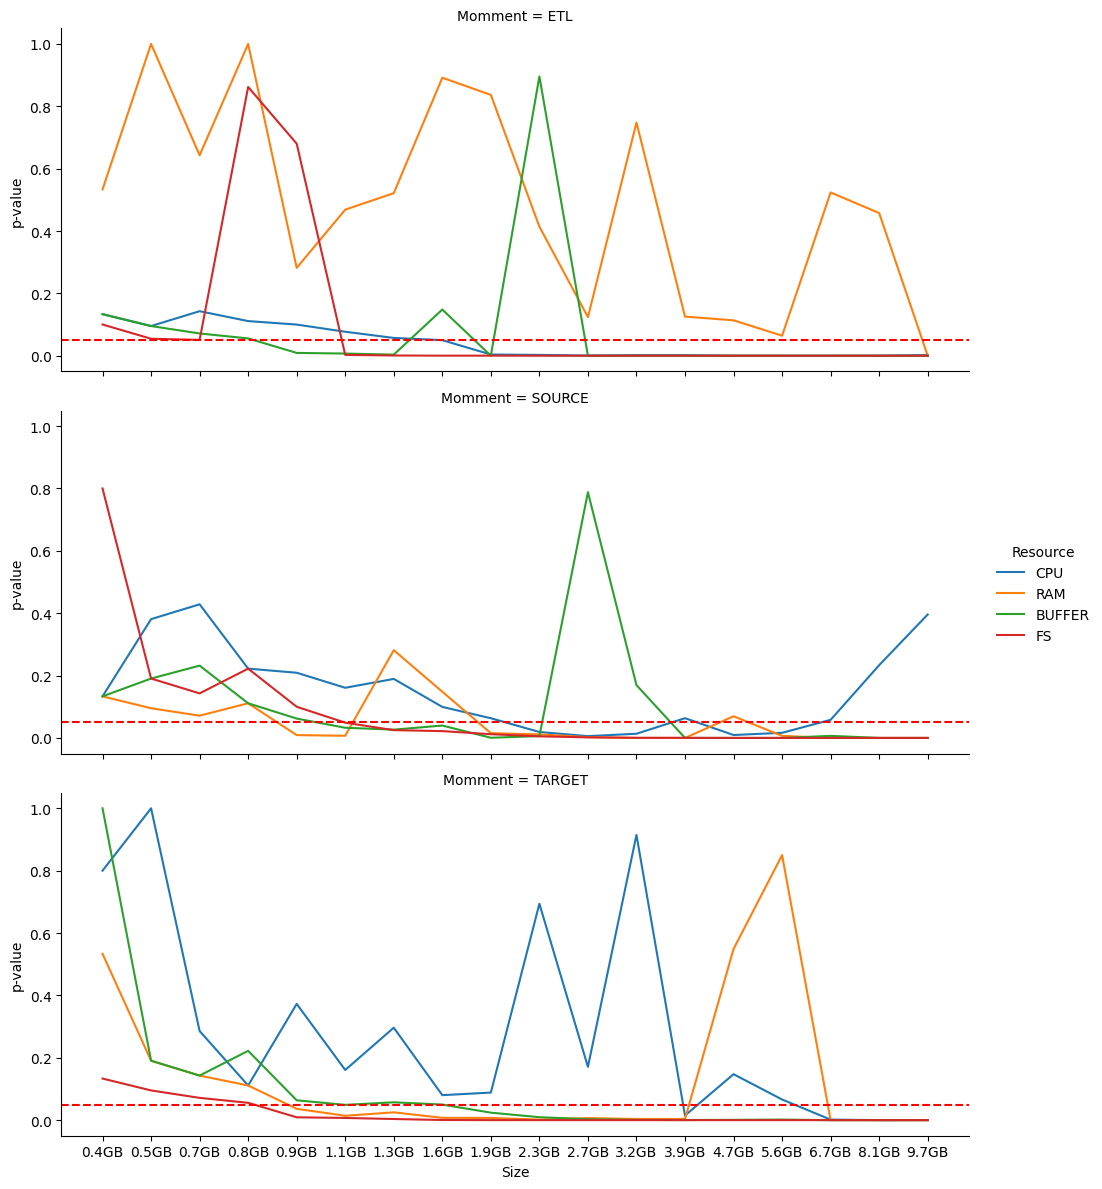

In [137]:
g = sns.relplot(x="Size", y="p-value", hue="Resource", col="Momment", col_wrap=1, data=df_result, kind="line", height=4, aspect=2.5)
g.refline(y=0.05, linestyle='--', linewidth=1.5, color='r')
# g = sns.lineplot(df_result, x="Size", y="p-value", hue="Momment", style="Momment", markers=True, dashes=False)
# g.set_xticks(range(len(x_tick_labels)))
# g.set_xticklabels(g.get_xticklabels(),rotation=270)
# # Y axis precision of 0.01, show all numbers in the axis
# # g.set_yticks(np.arange(0, 0.5, 0.05))
# # horizontal line at 0.05
# g.axhline(0.05, ls='--', color='r')
# # text at 0.05
# g.text(0.5, 0.05, "0.05", color="r", ha="right", va="bottom")
plt.show()

In [138]:
df_result

,Momment,Resource,Size,Sf,p-value
0,ETL,CPU,0.4GB,3,0.133333
1,ETL,CPU,0.5GB,4,0.095238
2,ETL,CPU,0.7GB,5,0.142857
3,ETL,CPU,0.8GB,6,0.111111
4,ETL,CPU,0.9GB,7,0.1
...,...,...,...,...,...
211,TARGET,FS,4.7GB,35,0.0
212,TARGET,FS,5.6GB,42,0.0
213,TARGET,FS,6.7GB,50,0.0
214,TARGET,FS,8.1GB,60,0.0
